In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
fashion_mnist = datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
from tensorflow.image import resize
X_train_1 = np.expand_dims(train_images, axis=-1)
X_train_1 = np.repeat(X_train_1, 3, axis=-1)
X_train_resize = resize(X_train_1, [32,32])

X_test_1 = np.expand_dims(test_images, axis=-1)
X_test_1 = np.repeat(X_test_1, 3, axis=-1)
X_test_resize = resize(X_test_1, [32,32])
print(np.shape(X_test_resize))

y_train = train_labels
y_test = test_labels

train_Y_one_hot = tf.keras.utils.to_categorical(train_labels)
test_Y_one_hot = tf.keras.utils.to_categorical(test_labels)

(10000, 32, 32, 3)


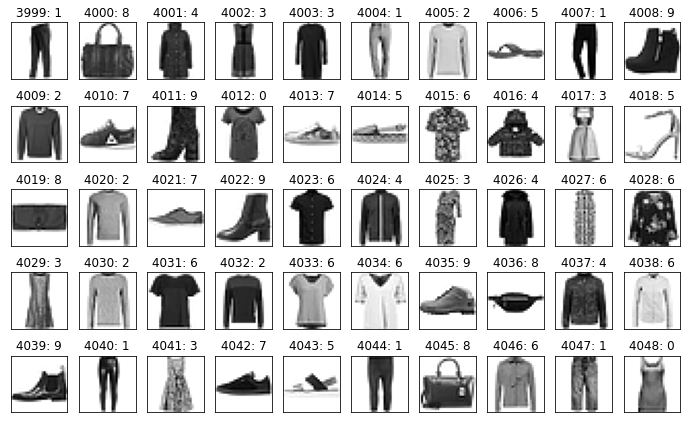

In [4]:
# Imagem no conjunto de treinamento
plt.figure(figsize=(12,12))
for i in range(50):
    plt.subplot(8,10,i+1)
    plt.imshow(train_images[3999+i], cmap=plt.cm.gray_r);
    plt.title(str(3999+i)+': '+ str(train_labels[3999+i]));
    plt.xticks([]);
    plt.yticks([]);

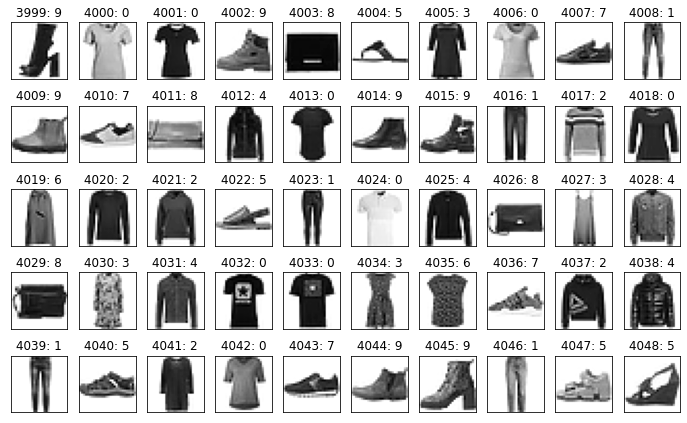

In [5]:
# Imagem no conjunto de teste
plt.figure(figsize=(12,12))
for i in range(50):
    plt.subplot(8,10,i+1)
    plt.imshow(test_images[3999+i], cmap=plt.cm.gray_r);
    plt.title(str(3999+i)+': '+ str(test_labels[3999+i]));
    plt.xticks([]);
    plt.yticks([]);

In [6]:
print('Train shape: {}, {}'.format(X_train_resize.shape,y_train.shape))
print('Test shape: {}, {}'.format(X_test_resize.shape,y_test.shape))

Train shape: (60000, 32, 32, 3), (60000,)
Test shape: (10000, 32, 32, 3), (10000,)


In [7]:
base_model = tf.keras.applications.VGG16(classes=10, include_top = True, weights = None, input_shape = (32,32,3))
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [8]:
opt = optimizers.Adamax(learning_rate=1e-5)
base_model.compile(optimizer= opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)

In [ ]:
history = base_model.fit(X_train_resize, train_Y_one_hot, batch_size=100, epochs=10, validation_data=(X_test_resize, test_Y_one_hot), verbose=1, callbacks=[es, mc, lr])

Epoch 1/10
600/600 [==============================] - 5644s 9s/step - loss: 0.8911 - accuracy: 0.6784 - val_loss: 0.6563 - val_accuracy: 0.7396

Epoch 00001: val_accuracy improved from -inf to 0.73960, saving model to best_model.h5
Epoch 2/10
600/600 [==============================] - 5587s 9s/step - loss: 0.5658 - accuracy: 0.7860 - val_loss: 0.5403 - val_accuracy: 0.7977

Epoch 00002: val_accuracy improved from 0.73960 to 0.79770, saving model to best_model.h5
Epoch 3/10
600/600 [==============================] - 5126s 9s/step - loss: 0.4972 - accuracy: 0.8137 - val_loss: 0.5034 - val_accuracy: 0.8142

Epoch 00003: val_accuracy improved from 0.79770 to 0.81420, saving model to best_model.h5
Epoch 4/10
600/600 [==============================] - 5438s 9s/step - loss: 0.4572 - accuracy: 0.8333 - val_loss: 0.4576 - val_accuracy: 0.8345

Epoch 00004: val_accuracy improved from 0.81420 to 0.83450, saving model to best_model.h5
Epoch 5/10
295/600 [=============>................] - ETA: 43:3

In [ ]:
base_model2 = tf.keras.applications.VGG16(classes=10, include_top = False, input_shape = (32,32,3))
print(base_model2.summary())

In [ ]:
x = base_model2.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='Softmax')(x)

In [ ]:
classificador = Model(inputs=base_model2.input, outputs=predictions)
print(classificador.summary())

In [ ]:
for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
classificador.compile(optimizer= 'Adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)
history = classificador.fit(X_train_resize, train_Y_one_hot, batch_size=256, epochs=100, validation_data=(X_test_resize, test_Y_one_hot), verbose=1, callbacks=[es, mc, lr])

In [ ]:
for i, layer in enumerate(classificador.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in classificador.layers[:11]:
   layer.trainable = False
for layer in classificador.layers[11:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
classificador.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)
history = classificador.fit(X_train_resize, train_Y_one_hot, batch_size=256, epochs=100, validation_data=(X_test_resize, test_Y_one_hot), verbose=1, callbacks=[es, mc, lr])

In [ ]:
best_score = max(hist.history['accuracy'])

print(best_score)

#Criando a rede 2

In [ ]:
from tensorflow.image import resize
X_train_2 = np.expand_dims(train_images, axis=-1)
X_train_2 = np.repeat(X_train_2, 1, axis=-1)
X_train_resize_2 = resize(X_train_2, [28,28])

X_test_2 = np.expand_dims(test_images, axis=-1)
X_test_2 = np.repeat(X_test_2, 1, axis=-1)
X_test_resize_2 = resize(X_test_2, [28,28])
print(np.shape(X_test_resize_2))

train_Y_one_hot = tf.keras.utils.to_categorical(train_labels)
test_Y_one_hot = tf.keras.utils.to_categorical(test_labels)

In [ ]:
classificador = models.Sequential()
classificador.add(Flatten(input_shape=(28,28,1)))
classificador.add(Dense(units=28*28, use_bias=True, activation= 'relu'))
classificador.add(Dense(units=1024, activation= 'relu'))
classificador.add(Dense(units=2048, activation= 'relu'))
classificador.add(Dense(units=2048, activation= 'relu'))
classificador.add(Dense(units=10, activation= 'softmax'))

In [ ]:
classificador.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
print(classificador.summary())

In [ ]:
history = classificador.fit(X_train_resize_2, train_Y_one_hot, batch_size=256, epochs=1, validation_data=(X_test_resize_2, test_Y_one_hot))